In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np
import yfinance as yf
import re

# Reuters

In [18]:
sp500 = yf.Ticker("^GSPC").history(period="max")
DAX = yf.Ticker("^GDAXI").history(period="max")
indexList =[sp500,DAX]#,MIB, IBEX, HSENG,N225,CAC,KOSPI]
for i in indexList:
    i["Mean"] = (i["Open"]+i["High"]+i["Low"]+i["Close"])/4
    i["Vola"] = (i["High"]-i["Low"])/i["Mean"]
    i["Mom"] = i["Close"]-i["Open"]

In [19]:
soup = []
for i in range(1,500,1):
    URL = 'https://uk.reuters.com/news/archive/businessnews?view=page&page='+str(i)+'&pageSize=10'
    page =get(URL)
    soup.append(BeautifulSoup(page.content, 'html.parser'))


soup is a list of object. Each object represents a whole page on Reuters.  

Let us make a DataFrame for all the stories.

In [20]:
def getPgDF(wordlist0,wordlist1,pgObjList):
    timelist = []
    headerlist = []
    abstractlist = []
    for pgNr in range(len(pgObjList)):
        indivPG = pgObjList[pgNr].find_all("div", class_ = "story-content")
        for i in indivPG:
            tempabs = str(i.p)
            temptitle = str(i.find_all("h3", class_ = "story-title"))
            temptime = str(i.find_all("span", class_ = "timestamp"))[25:-8]
            
            if any(elem in tempabs for elem in wordlist0)& any(elem in tempabs for elem in wordlist1):
                abstractlist.append(True)
            else:
                abstractlist.append(False)
        
            if any(elem in temptitle for elem in wordlist0)& any(elem in temptitle for elem in wordlist1):
                headerlist.append(True)
            else:
                headerlist.append(False)
        
            if "BST" in temptime:
                timelist.append(datetime.today().strftime('%d-%b-%Y'))
            elif len(temptime)==0:
                timelist.append(np.nan)
            else:
                convdate = datetime.strptime(temptime, '%d %b %Y').strftime('%d %b %Y')
                timelist.append(convdate)
    pageDF = pd.DataFrame({"Date" : pd.to_datetime(timelist),
                          "Header" : headerlist,
                          "Abstract" : abstractlist}).dropna()
    return pageDF

def getTrueStats(df):
    freqTrue = []
    for i in range(len(df)):
        if df["top"][i] == True:
            freqTrue.append(df["freq"][i])
        else:
            freqTrue.append(df["count"][i]-df["freq"][i])
    return np.array(freqTrue)

def getPgStats(pgdf):
    pgSummary = pgdf.groupby("Date").describe()
    
    datelist = pgSummary.index
    nrStory = pgSummary["Header"]["count"]
    nrTrueHeader = getTrueStats(pgSummary["Header"])
    ratTrueHeader = nrTrueHeader/nrStory
    nrTrueAbs = getTrueStats(pgSummary["Abstract"])
    ratTrueAbs = nrTrueAbs/nrStory
    tempDF = pd.DataFrame({
        #"Date" : datelist,
        "NrStory" : nrStory,
        "Header" : nrTrueHeader,
        "Abstract" : nrTrueAbs,
        "rHeader" : ratTrueHeader,
        "rAbstract" : ratTrueAbs
    })

    return tempDF

In [21]:
pageDF = getPgDF(["virus","covid","pandem","outbreak","crisi","spread"],["virus","covid","pandem","outbreak","crisi","spread"],soup)
resDF = getPgStats(pageDF)

pageDFGood = getPgDF(["virus","covid","pandem","outbreak","crisi","spread"],["combat","help","improv","recover"],soup)
resDFGood = getPgStats(pageDFGood)

pageDFBad = getPgDF(["virus","covid","pandem","outbreak","crisi","spread"],["dead","death", "fear"],soup)
resDFBad = getPgStats(pageDFBad)

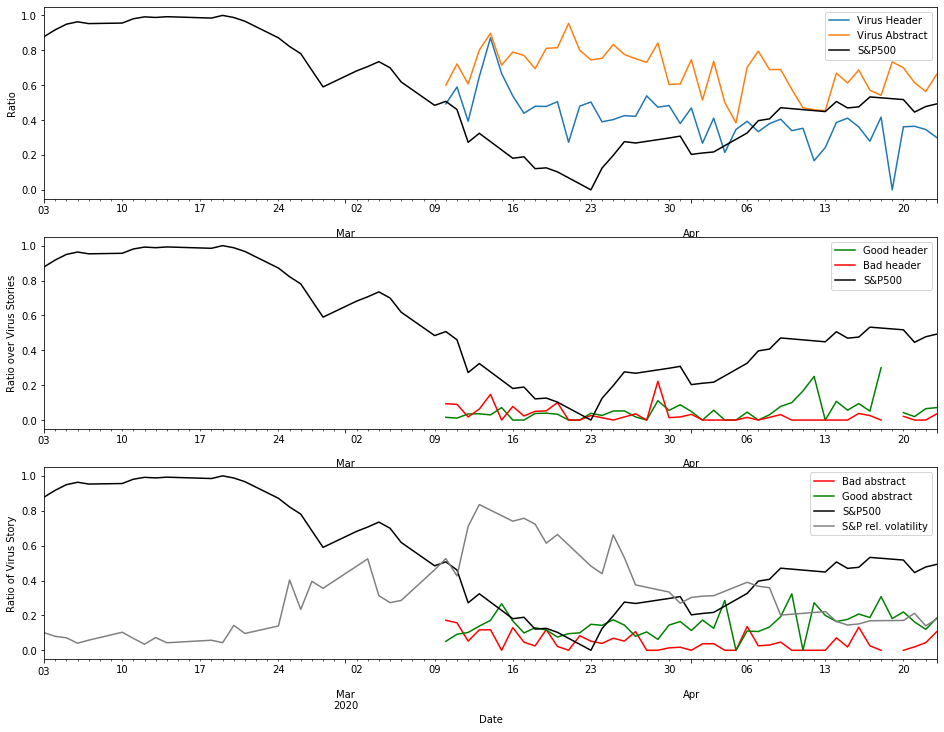

In [22]:
fig, ax = plt.subplots(nrows=3, figsize=(16,12))
resDF["2020-02"::].plot(y="rHeader",ax=ax[0])
resDF["2020-02"::].plot(y="rAbstract",ax=ax[0])
((sp500["Mean"]["2020-02"::]-min(sp500["Mean"]["2020-02"::]))/(max(sp500["Mean"]["2020-02"::])-min(sp500["Mean"]["2019-12"::]))).plot(ax=ax[0],c="black")
ax[0].set_ylabel("Ratio")
ax[0].legend(["Virus Header","Virus Abstract","S&P500"])

(resDFGood["2020-02"::]["Header"]/resDF["2020-02"::]["Header"]).plot(ax=ax[1],c="green")
(resDFBad["2020-02"::]["Header"]/resDF["2020-02"::]["Header"]).plot(ax=ax[1],c="red")
((sp500["Mean"]["2020-02"::]-min(sp500["Mean"]["2020-02"::]))/(max(sp500["Mean"]["2020-02"::])-min(sp500["Mean"]["2019-12"::]))).plot(ax=ax[1],c="black")
ax[1].set_ylabel("Ratio over Virus Stories")
ax[1].legend(["Good header","Bad header","S&P500"])

(resDFBad["2020-02"::]["Abstract"]/resDF["2020-02"::]["Header"]).plot(ax=ax[2],c="red")
(resDFGood["2020-02"::]["Abstract"]/resDF["2020-02"::]["Abstract"]).plot(ax=ax[2],c="green")
((sp500["Mean"]["2020-02"::]-min(sp500["Mean"]["2020-02"::]))/(max(sp500["Mean"]["2020-02"::])-min(sp500["Mean"]["2020-02"::]))).plot(ax=ax[2],c="black")
(10*sp500["Vola"]["2020-02"::]).plot(ax=ax[2],c="gray")
ax[2].set_ylabel("Ratio of Virus Story")
ax[2].legend(["Bad abstract","Good abstract","S&P500","S&P rel. volatility"])

# FT

In [197]:
soupFT = []
for i in range(1,100,1):
    URL = 'https://www.ft.com/markets?page='+str(i)
    page =get(URL)
    soupFT.append(BeautifulSoup(page.content, 'html.parser'))


FTgetPgDF gets all messages and date and categories.

In [198]:
def FTgetPgDF(pgObjList):
    categorylist=[]
    timelist = []
    titlelist = []
    contentlist = []
    for pgNr in range(len(pgObjList)):
        indivPG = pgObjList[pgNr].find_all("li", class_="o-teaser-collection__item o-grid-row")
        for i in indivPG:
            
            temptitle = i.find_all("div", class_="o-teaser__heading")
            titlelist.append(temptitle)
            tempcontent = i.p
            contentlist.append(tempcontent)
            
            temptime = i.find_all("time")
            timelist.append(temptime)
            
            tempcateg = i.a
            categorylist.append(tempcateg)

    pageDFtemp = pd.DataFrame({"Date" : timelist,
                          "Title" : titlelist,
                          "Content" : contentlist,
                          "Category" : categorylist
                            }).dropna()
    
    
    
    finaltimelist = []
    for j in range(len(pageDFtemp)):
        try: 
            test1 = datetime.strptime(pageDFtemp["Date"][j][0].get_text(), '%A, %d %B, %Y').date()
            finaltimelist.append(test1)
        except:
            finaltimelist.append(0)
    
    
    finalcateglist = []
    for j in range(len(pageDFtemp)):
        try: 
            test1 = pageDFtemp["Category"][j].get_text()
            finalcateglist.append(test1)
        except:
            finalcateglist.append(0)
        
    finalcontentlist = []
    for j in range(len(pageDFtemp)):
        try: 
            #test1 = pageDFtemp["Title"][j].get_text()
            test2 = pageDFtemp["Content"][j].get_text()
            test1 = pageDFtemp["Title"][j][0].get_text()
            finalcontentlist.append(test1+" "+ test2)
        except:
            finalcontentlist.append(0)

    
    pageDF = pd.DataFrame({"Date" : finaltimelist,
                          "Headline" : finalcontentlist,
                          "Category" : finalcateglist
                            })
    pageDF=pageDF[(pageDF != 0).all(1)]
    pageDF["Date"] = pd.to_datetime(pageDF["Date"])
    return pageDF

def getTrueStats(df):
    freqTrue = []
    for i in range(len(df)):
        if df["top"][i] == True:
            freqTrue.append(df["freq"][i])
        else:
            freqTrue.append(df["count"][i]-df["freq"][i])
    return np.array(freqTrue)

def FTgetPgStats(pgdf):
    pgSummary = pgdf.groupby("Date").describe()
    
    datelist = pgSummary.index
    nrStory = pgSummary["Headline"]["count"]
    nrTrueHeader = getTrueStats(pgSummary["Headline"])
    ratTrueHeader = nrTrueHeader/nrStory
    tempDF = pd.DataFrame({
        #"Date" : datelist,
        "NrStory" : nrStory,
        "Headline" : nrTrueHeader,
        "rHeadline" : ratTrueHeader,
    })

    return tempDF


def filterFTpgDF(wordlist0,wordlist1,FTDF):
    newcontlist = []
    sample = FTDF["Headline"].tolist()
    tempcont=0
    for tempcont in sample:
        if any(elem in tempcont for elem in wordlist0)& any(elem in tempcont for elem in wordlist1):
            newcontlist.append(True)
        else:
            newcontlist.append(False)
    newFTDF = pd.DataFrame({})
    newFTDF["Date"]=FTDF["Date"]
    newFTDF["Headline"]=newcontlist
    newFTDF["Category"]=FTDF["Category"]
    return newFTDF

In [199]:
FTSummary = FTgetPgDF(soupFT)

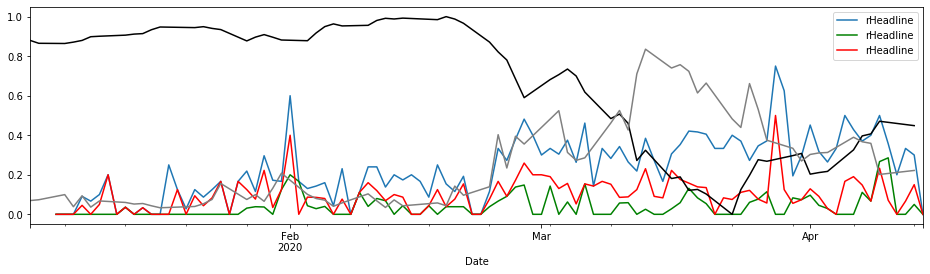

In [200]:
wordlist0=["panic","threa","virus","covid","pandem","outbreak","crisi","plagu"]
goodwords = ["combat","help","improv","recover","boost","rescu","gain","good","high","attrac","lift","agree","provid"]
badwords = ["dead","death", "fear","plung","roil","los","wors","low","fall","threa","drop","strug","block"]

covidFTDF=filterFTpgDF(wordlist0,wordlist0,FTSummary)
goodcovidFTDF = filterFTpgDF(wordlist0,goodwords,FTSummary)
badcovidFTDF = filterFTpgDF(wordlist0,badwords,FTSummary)
resFTDF = FTgetPgStats(covidFTDF)
goodresFTDF = FTgetPgStats(goodcovidFTDF)
badresFTDF = FTgetPgStats(badcovidFTDF)
fig, ax = plt.subplots(figsize=(16,4))
resFTDF.plot(y="rHeadline",ax=ax)
(goodresFTDF).plot(y="rHeadline",ax=ax, c="green")
(badresFTDF).plot(y="rHeadline",ax=ax, c="red")
((sp500["Mean"]["2020-01"::]-min(sp500["Mean"]["2020-01"::]))/(max(sp500["Mean"]["2020-01"::])-min(sp500["Mean"]["2020-01"::]))).plot(ax=ax,c="black")
(10*sp500["Vola"]["2020-01"::]).plot(ax=ax,c="gray")

In [201]:
datelist = FTSummary["Date"]
temppd = pd.DataFrame()
for i in datelist:
    tempres = FTSummary[FTSummary.Date.isin(i)]["Category"].value_counts()
    temppd = pd.concat([temppd, tempres], axis=1, sort=True)
temppd.columns = datelist
temppd=temppd.T

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [Timestamp]

In [ ]:
temppd.Coronavirus.groupby("Date").describe()["count"].plot()
temppd.Equities.groupby("Date").describe()["count"].plot()
temppd.groupby("Date").describe()["count"].plot()

In [3]:
import yfinance as yf

In [4]:
sp500 = yf.Ticker("^GSPC").history(period="max")
DAX = yf.Ticker("^GDAXI").history(period="max")
for i in indexList:
    i["Mean"] = (i["Open"]+i["High"]+i["Low"]+i["Close"])/4
    i["Vola"] = i["High"]-i["Low"]
    i["Mom"] = i["Close"]-i["Open"]

NameError: name 'indexList' is not defined

In [2]:
class stock():
    def __init__(self, yticker):
        self.yticker = yticker
    
    def load_rawdata(self):
        return yf.Ticker(self.yticker).history(period="max")
    
    def load_data(self):
        newdata = self.load_rawdata()
        newdata["Mean"] = (newdata["Open"]+newdata["High"]+newdata["Low"]+newdata["Close"])/4
        newdata["Volatility"] = (newdata["High"]-newdata["Low"])/newdata["Mean"]
        newdata["Momentum"] = (newdata["Close"]-newdata["Open"])/newdata["Mean"]
        return newdata

In [5]:
sp500 = stock("FEZ")

In [6]:
sp500.load_data()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Mean,Volatility,Momentum
Date,,,,,,,,,,
2002-10-21,13.97,14.33,13.97,14.33,46100,0.0,0,14.1500,0.025442,0.025442
2002-10-22,14.10,14.10,14.05,14.05,2100,0.0,0,14.0750,0.003552,-0.003552
2002-10-23,13.66,13.69,13.38,13.69,87200,0.0,0,13.6050,0.022786,0.002205
2002-10-24,13.89,13.89,13.61,13.63,61900,0.0,0,13.7550,0.020356,-0.018902
2002-10-25,13.79,13.79,13.79,13.79,500,0.0,0,13.7900,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2020-04-28,31.08,31.12,30.62,30.63,2444000,0.0,0,30.8625,0.016201,-0.014581
2020-04-29,31.39,31.84,31.31,31.69,2322600,0.0,0,31.5575,0.016795,0.009506
2020-04-30,31.27,31.27,30.87,31.07,4322400,0.0,0,31.1200,0.012853,-0.006427


In [7]:
STOXX50=stock("LVE.PA")
RealSTOXX50=stock("FEZ")
SP500=stock("^GSPC")

In [8]:
STOXX50Data = STOXX50.load_data()
RealSTOXX50Data = RealSTOXX50.load_data()
SP500Data = SP500.load_data()

## Compare 2x lev data with real data STOXX50

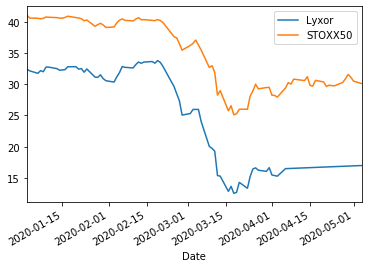

In [9]:
STOXX50Data["Mean"]["2020":].plot()
RealSTOXX50Data["Mean"]["2020":].plot()

plt.legend(["Lyxor","STOXX50"])

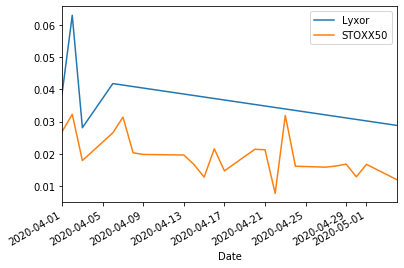

In [10]:
STOXX50Data["Volatility"]["2020-04":].plot()
RealSTOXX50Data["Volatility"]["2020-04":].plot()

plt.legend(["Lyxor","STOXX50"])

In [20]:
commonlist = pd.concat([RealSTOXX50Data, STOXX50Data], axis=1, sort=False).dropna().index

In [21]:
RealSTOXX50Data[RealSTOXX50Data.index.isin(commonlist)]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Mean,Volatility,Momentum
Date,,,,,,,,,,
2008-01-02,41.78,41.87,41.31,41.37,186200,0.0,0,41.5825,0.013467,-0.009860
2008-01-03,41.38,41.61,41.38,41.50,42600,0.0,0,41.4675,0.005547,0.002894
2008-01-04,41.35,41.35,40.65,40.65,114800,0.0,0,41.0000,0.017073,-0.017073
2008-01-07,41.04,41.12,40.82,40.97,128800,0.0,0,40.9875,0.007319,-0.001708
2008-01-08,41.31,41.45,40.49,40.54,96700,0.0,0,40.9475,0.023445,-0.018805
...,...,...,...,...,...,...,...,...,...,...
2020-03-31,29.52,29.80,29.12,29.51,4036100,0.0,0,29.4875,0.023061,-0.000339
2020-04-01,28.45,28.66,27.90,28.01,4016300,0.0,0,28.2550,0.026898,-0.015572
2020-04-02,27.88,28.70,27.79,28.42,4320800,0.0,0,28.1975,0.032272,0.019151


In [22]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0]
def corr(x, y):
    return stats.pearsonr(x, y)[1]

In [428]:
r2list =[]
datelist =pd.date_range(start="2015-09",end="2020-05", freq="M").strftime("%Y-%m")
for year in datelist:
    tempr2 = r2(RealSTOXX50Data[RealSTOXX50Data.index.isin(commonlist)][year]["Mean"],STOXX50Data[STOXX50Data.index.isin(commonlist)][year]["Mean"])
    r2list.append(tempr2)

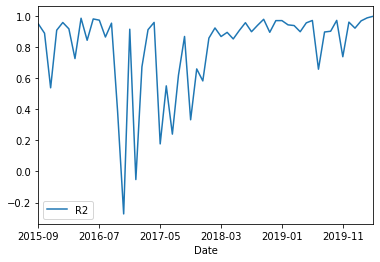

In [429]:
newdf=pd.DataFrame({"Date":datelist,"R2":r2list})
newdf=newdf.set_index("Date")
newdf.plot()

C:\Users\X\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


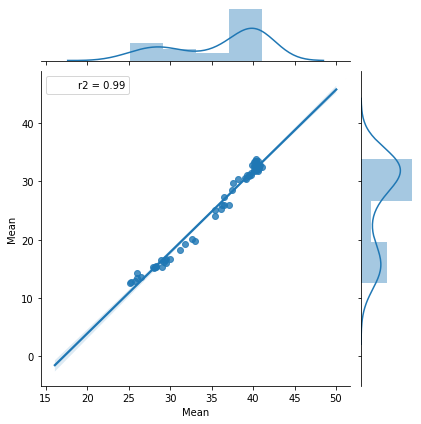

In [430]:
sns.jointplot(x=RealSTOXX50Data[RealSTOXX50Data.index.isin(commonlist)]["2020"]["Mean"],
            y=STOXX50Data[STOXX50Data.index.isin(commonlist)]["2020"]["Mean"], kind="reg", stat_func=r2)


## Compare STOXX50 with SP500

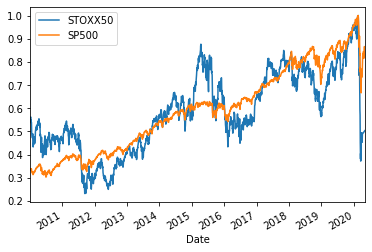

In [11]:
(STOXX50Data["Mean"]["2010":]/STOXX50Data["Mean"]["2010":].max()).plot()
(SP500Data["Mean"]["2010":]/SP500Data["Mean"]["2010":].max()).plot()
plt.legend(["STOXX50","SP500"])

In [12]:
commonlist = pd.concat([STOXX50Data, SP500Data], axis=1, sort=False).dropna().index

In [13]:
r2list =[]
corrlist = []
datelist =pd.date_range(start="2015-09",end="2020-05", freq="M").strftime("%Y-%m")
for year in datelist:
    tempr2 = r2(STOXX50Data[STOXX50Data.index.isin(commonlist)][year]["Mean"],SP500Data[SP500Data.index.isin(commonlist)][year]["Mean"])
    tempcorr = corr(STOXX50Data[STOXX50Data.index.isin(commonlist)][year]["Mean"],SP500Data[SP500Data.index.isin(commonlist)][year]["Mean"])
    r2list.append(tempr2)
    corrlist.append(tempcorr)

NameError: name 'r2' is not defined

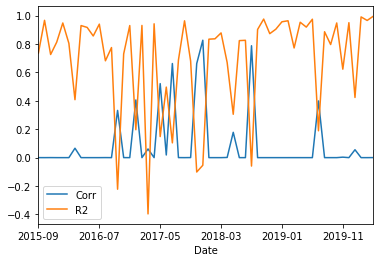

In [434]:
newdf=pd.DataFrame({"Date":datelist,"Corr":corrlist,"R2":r2list})
newdf=newdf.set_index("Date")
newdf.plot()

C:\Users\X\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


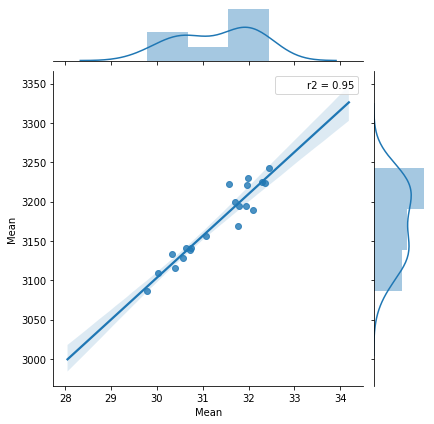

In [435]:
sns.jointplot(x=STOXX50Data[STOXX50Data.index.isin(commonlist)]["2019-12"]["Mean"],
            y=SP500Data[SP500Data.index.isin(commonlist)]["2019-12"]["Mean"], kind="reg", stat_func=r2)
